In [1]:
using Revise

In [4]:
using Distributed
procs_to_use = 12
if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end
;

In [9]:
@everywhere using QuantumStates, OpticalBlochEquations, UnitsToValue

@everywhere using DifferentialEquations, StructArrays, StaticArrays, Parameters

@everywhere import Distributions: Normal, Geometric, Exponential
@everywhere using ProgressMeter

using Plots

using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

@everywhere begin
    include("../misc/helper_functions.jl")
    include("../misc/compute_size_temperature.jl")
    include("define_YO_structure.jl")
    include("define_blueMOT_params.jl")
    # include("define_blueMOT_prob.jl")
end
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f] (cache misses: include_dependency fsize change (12))


In [10]:
typeof(ωs)

LoadError: UndefVarError: `ωs` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

# 1+1 YO MOT

In [5]:
n_iterations = 2
n_trajectories = 20
n_trajectories_diffusion = 20000
n_times = 30
diffusion_t_end = 5e-6
diffusion_τ_total = 5e-6

(diffusions, diffusion_errors, diffusions_over_time) = compute_diffusion_iteratively(
    prob, prob_func_YO!, prob_diffusion, prob_func_diffusion_YO!, 
    n_iterations, n_trajectories, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

Progress: 100%|█████████████████████████████████████████| Time: 1:28:40
Progress: 100%|█████████████████████████████████████████| Time: 0:21:07m56m
Progress: 100%|█████████████████████████████████████████| Time: 0:20:22
Progress: 100%|█████████████████████████████████████████| Time: 1:19:35
Progress: 100%|█████████████████████████████████████████| Time: 0:20:33
Progress: 100%|█████████████████████████████████████████| Time: 0:20:42


In [33]:
diffusion = diffusions[1,:,end]
@everywhere prob.p.diffusion_constant = $[diffusion[1], diffusion[1], diffusion[2]]
@time sols = distributed_solve(40, prob, prob_func_YO!, scan_nothing, [0])
;

Progress: 100%|█████████████████████████████████████████| Time: 2:44:31


10099.717425 seconds (3.52 M allocations: 406.396 MiB, 0.01% gc time, 1 lock conflict)


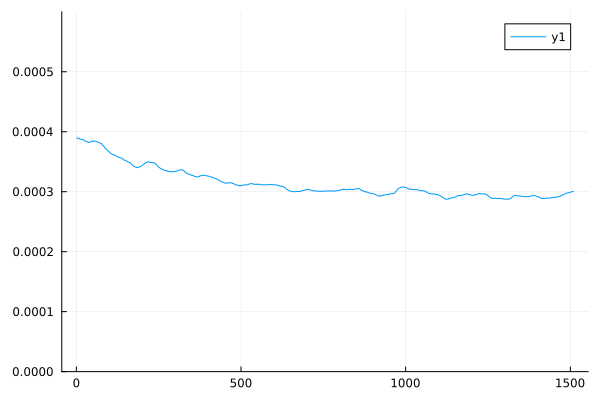

In [34]:
σs = σ_vs_time(sols[1])
plot(σs, ylim=(0, 600e-6))

In [38]:
σs[750:end] |> mean

0.0002961012297722071

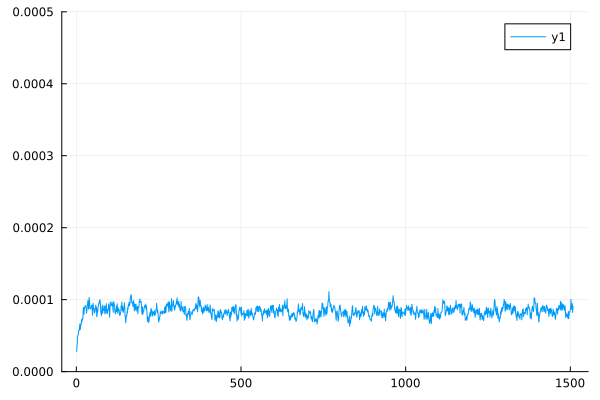

In [35]:
Ts = T_vs_time(sols[1])
plot(Ts, ylim=(0, 0.0005))

In [37]:
Ts[750:end] |> mean

8.377771644369917e-5

# 1+2 YO MOT

In [77]:
@everywhere begin 
    include("define_blueMOTconveyor_params_multiple.jl")
    include("define_blueMOT_prob.jl")
end

In [55]:
n_iterations = 2
n_trajectories = 20
n_trajectories_diffusion = 5000
n_times = 30
diffusion_t_end = 2e-6
diffusion_τ_total = 2e-6

(diffusions, diffusion_errors, diffusions_over_time) = compute_diffusion_iteratively(
    prob, prob_func_YO!, prob_diffusion, prob_func_diffusion_YO!, 
    n_iterations, n_trajectories, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:24:05
Progress: 100%|█████████████████████████████████████████| Time: 0:06:23m:57
Progress: 100%|█████████████████████████████████████████| Time: 0:06:06
Progress: 100%|█████████████████████████████████████████| Time: 0:24:50
Progress: 100%|█████████████████████████████████████████| Time: 0:06:20
Progress: 100%|█████████████████████████████████████████| Time: 0:06:19


In [63]:
diffusions[1,:,2], diffusion_errors[1,:,2]

([0.013412301682421943, 0.013702094332266287], [0.0004750700037733854, 0.0005217144227341061])

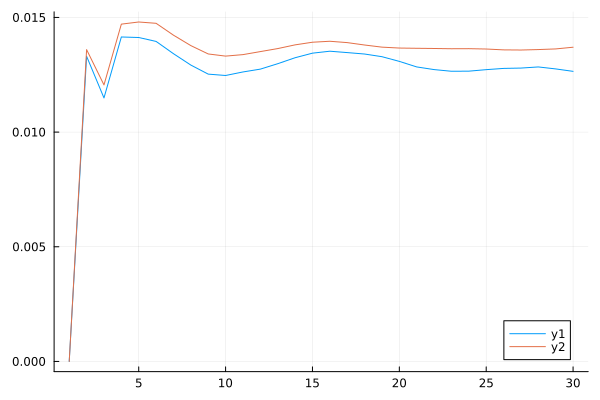

In [69]:
diffusions_over_time[1,2,:,:]' |> plot

In [4]:
diffusions = [0.013412301682421943, 0.013702094332266287]

2-element Vector{Float64}:
 0.013412301682421943
 0.013702094332266287

In [5]:
diffusion = diffusions[1,:,end]
@everywhere prob.p.diffusion_constant = $[diffusion[1], diffusion[1], diffusion[2]]
@time sols = distributed_solve(200, prob, prob_func_YO!, scan_nothing, [0])
;

LoadError: BoundsError: attempt to access 1-element Vector{Float64} at index [2]

In [ ]:
σs = σ_vs_time(sols[1])
plot(σs, ylim=(0, 600e-6))

In [ ]:
Ts = T_vs_time(sols[1])
plot(Ts, ylim=(0, 0.0005))

In [75]:
total_sats = (0.3:0.2:2.1) .* total_sat
# total_sats = [0.7] .* total_sat
@everywhere function update_total_s!(prob, total_sat)
    prob.p.sim_params.total_sat = total_sat
    return nothing
end
;

In [76]:
(sols_no_diffusion, sols_with_diffusion1, sols_with_diffusion2, diffusion, diffusion_error, diffusion_over_time1, diffusion_over_time2) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_total_s!, total_sats
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:19:17
Progress: 100%|█████████████████████████████████████████| Time: 1:50:25m25m
Progress: 100%|█████████████████████████████████████████| Time: 7:07:06m
Progress: 100%|█████████████████████████████████████████| Time: 1:49:05
Progress: 100%|█████████████████████████████████████████| Time: 1:29:30


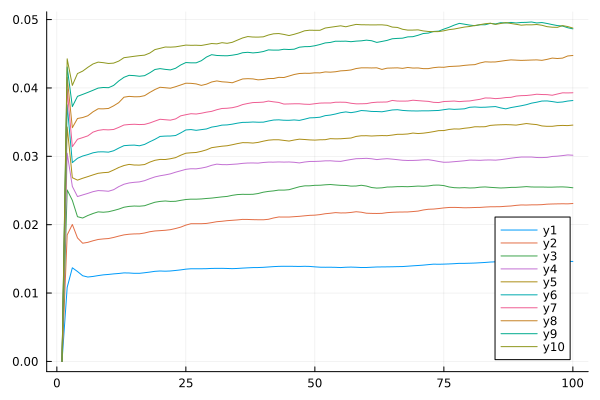

In [77]:
plot(diffusion_over_time2)

10-element Vector{Float64}:
 6.646200275119021e-5
 6.147365289385484e-5
 6.0298024757834574e-5
 6.293443068948016e-5
 6.679637881317331e-5
 7.06084086155722e-5
 7.92014080949135e-5
 8.325543312223929e-5
 9.80238724691001e-5
 9.220829735170344e-5

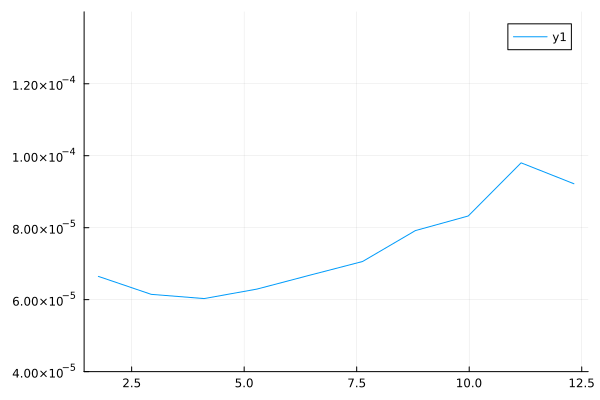

In [78]:
σxs = σx_fit.(sols_with_diffusion2)
σys = σy_fit.(sols_with_diffusion2)
σzs = σz_fit.(sols_with_diffusion2)
σs = (σxs .* σys .* σzs) .^ (1/3)
σs |> display
plot(total_sats, σs, ylim=(40e-6, 140e-6))

10-element Vector{Float64}:
 0.00016782846558329028
 0.0001749524407314544
 0.0001715774024549222
 0.0002078507203249674
 0.0002399701566923514
 0.0002642411782338924
 0.00025620625331206266
 0.0003370966554445925
 0.0003588477133888338
 0.00036876218544519844

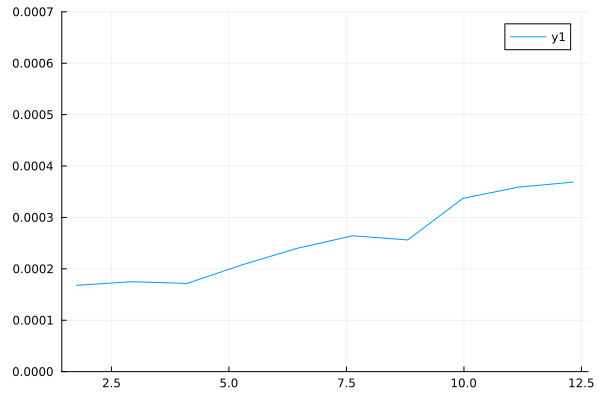

In [79]:
Txs = Tx_fit.(sols_with_diffusion2)
Tys = Ty_fit.(sols_with_diffusion2)
Tzs = Tz_fit.(sols_with_diffusion2)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
Ts |> display
plot(total_sats, Ts, ylim=(0, 700e-6))

In [53]:
detunings = [1.68, 3.16, 4.64, 6.12, 7.60, 9.08, 10.56, 12.04, 13.52, 15.00]
@everywhere function update_detuning!(prob, detuning)
    δ1 = +0.00
    δ2 = -1.00
    δ3 = +0.75
    Δ1 = 1e6 * (detuning + δ1) * (2π / Γ)
    Δ2 = 1e6 * (detuning + δ2) * (2π / Γ)
    Δ3 = 1e6 * (detuning + δ3) * (2π / Γ)
    prob.p.ωs[1] = prob.p.ω0s[end] - prob.p.ω0s[1] + Δ1
    prob.p.ωs[2] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ2
    prob.p.ωs[3] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ3
    return nothing
end
;

In [54]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_detuning!, detunings
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:37:01
Progress: 100%|█████████████████████████████████████████| Time: 6:14:57m:36
Progress: 100%|█████████████████████████████████████████| Time: 2:59:32
Progress: 100%|█████████████████████████████████████████| Time: 6:15:50
Progress: 100%|█████████████████████████████████████████| Time: 3:14:46


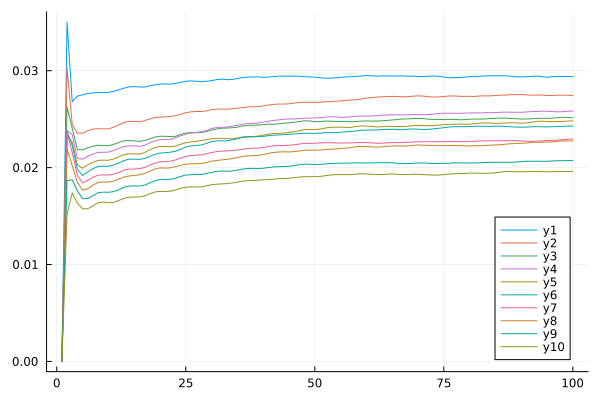

In [57]:
plot(diffusion_over_time)

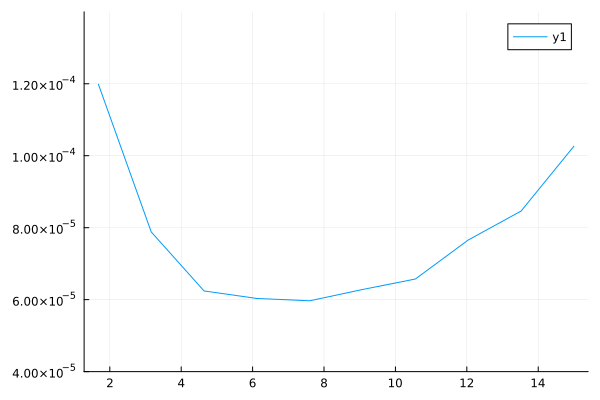

In [59]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(detunings, σs, ylim=(40e-6, 140e-6))

In [60]:
σs

10-element Vector{Float64}:
 0.00011988005603150527
 7.882251285790051e-5
 6.241630506592609e-5
 6.032761064279177e-5
 5.968793915001627e-5
 6.282395655547311e-5
 6.574450144565045e-5
 7.658359976030114e-5
 8.463088740795053e-5
 0.00010264953783378489

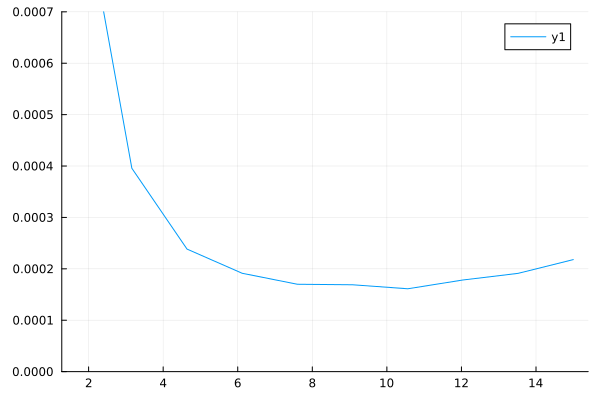

In [61]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(detunings, Ts, ylim=(0, 700e-6))

In [62]:
Ts

10-element Vector{Float64}:
 0.0009913594776639273
 0.000395583603111041
 0.00023833928599509616
 0.00019128027883086047
 0.000169955161381314
 0.0001689448220178511
 0.0001611663346537858
 0.00017826679261438816
 0.00019117885329586503
 0.00021792957095985674

In [63]:
δIIas = collect(range(+0.25, -3.25, 15))
@everywhere function update_δIIa!(prob, δIIa)
    detuning = 7.6
    δ2 = δIIa
    Δ2 = 1e6 * (detuning + δ2) * (2π / Γ)
    prob.p.ωs[2] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ2
    return nothing
end
; 

In [64]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_δIIa!, δIIas
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:54:39
Progress: 100%|█████████████████████████████████████████| Time: 9:14:24m41
Progress: 100%|█████████████████████████████████████████| Time: 4:31:22
Progress: 100%|█████████████████████████████████████████| Time: 8:50:15m
Progress: 100%|█████████████████████████████████████████| Time: 4:44:21


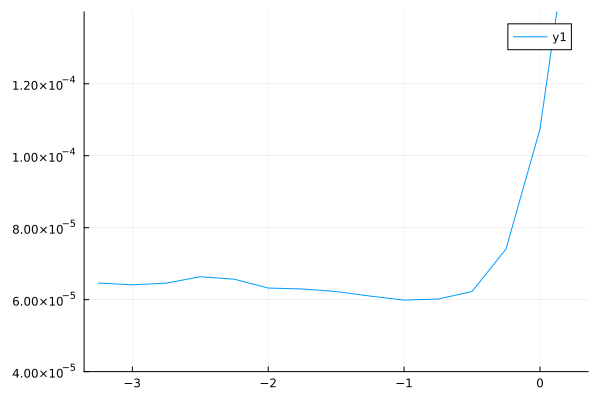

In [69]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(δIIas, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6, 140e-6))

In [70]:
σs

15-element Vector{Float64}:
 0.00017321060325200773
 0.00010738998805188012
 7.405926817644709e-5
 6.226173236875769e-5
 6.016894442149581e-5
 5.988398192107717e-5
 6.09948387477598e-5
 6.2251764538154e-5
 6.29688223781007e-5
 6.323097787495827e-5
 6.568274193722807e-5
 6.637192327060502e-5
 6.458631658485089e-5
 6.41233487927963e-5
 6.461972019230882e-5

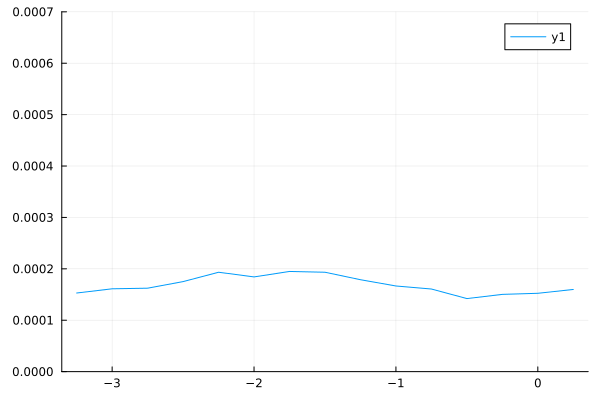

In [68]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(δIIas, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

In [71]:
Ts

15-element Vector{Float64}:
 0.00015985577394579862
 0.0001523745420871387
 0.00015026996475827088
 0.0001420926867340153
 0.00016070222819407587
 0.00016659279208645165
 0.00017879249142172782
 0.00019332750824337862
 0.00019486599203985506
 0.00018424359968492295
 0.00019330338560488163
 0.00017511977371729388
 0.00016230023160052355
 0.00016111953370618812
 0.0001529185934626929

In [81]:
collect(δIIbs)

15-element Vector{Float64}:
 -0.75
 -0.5357142857142857
 -0.32142857142857145
 -0.10714285714285714
  0.10714285714285714
  0.32142857142857145
  0.5357142857142857
  0.75
  0.9642857142857143
  1.1785714285714286
  1.3928571428571428
  1.6071428571428572
  1.8214285714285714
  2.0357142857142856
  2.25

In [10]:
# δIIbs = range(-0.75, 2.25, 15)
δIIbs = [2.25]
@everywhere function update_δIIb!(prob, δIIb)
    detuning = 7.6
    δ3 = δIIb
    Δ3 = 1e6 * (detuning + δ3) * (2π / Γ)
    prob.p.ωs[3] = prob.p.ω0s[end] - prob.p.ω0s[10] + Δ3
    return nothing
end
; 

In [11]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_δIIb!, δIIbs
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
Progress: 100%|█████████████████████████████████████████| Time: 0:03:46m03m
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55
Progress: 100%|█████████████████████████████████████████| Time: 0:03:35
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55


In [17]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot(δIIbs, (σxs .* σys .* σzs) .^ (1/3), ylim=(40e-6,140e-6))

LoadError: Data contains `Inf` or `NaN` values and a fit cannot be performed

In [21]:
σs

7.103561716153844e-5

In [23]:
Txs = Tx_fit(sols_with_diffusion)
Tys = Ty_fit(sols_with_diffusion)
Tzs = Tz_fit(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot(δIIbs, (Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

LoadError: Cannot convert Float64 to series data for plotting

In [24]:
Ts

0.00023016051584819508

In [190]:
B_div_C = 0.37/0.28
A_div_BC = [0, 0.37, 1.25, 2.60, 4.5, 7.0, 9.6, 12.6, 15.0, 18.3, 20.9, 22.9]
A_div_BC = A_div_BC ./ (31.4 .- A_div_BC)
A_div_C = A_div_BC .* (1 .+ B_div_C)
C_div_ABC = (A_div_C .+ B_div_C .+ 1).^(-1)
A_div_ABC = A_div_C .* C_div_ABC
B_div_ABC = B_div_C .* C_div_ABC
;

In [191]:
# all_params = [1300]
# B_div_C = 0.37/0.28
# A_div_C = (1.2 .* all_params / 1100)
# C_div_ABC = (A_div_C .+ B_div_C .+ 1).^(-1)
# A_div_ABC = A_div_C .* C_div_ABC
# B_div_ABC = B_div_C .* C_div_ABC
# ;

In [192]:
# Calculate the saturation parameters for IIa and IIb for a range of saturation ratios
sat_ratios = zip(B_div_ABC, C_div_ABC, A_div_ABC)

@everywhere function update_sat_ratios!(prob, sat_ratios)
    I_sat_ratio, IIa_sat_ratio, IIb_sat_ratio = sat_ratios
    prob.p.sim_params.s1_ratio = I_sat_ratio
    prob.p.sim_params.s2_ratio = IIa_sat_ratio
    prob.p.sim_params.s3_ratio = IIb_sat_ratio
    return nothing
end

# II_total_sat = sats[2] + sats[3]
# IIab_sats = zip(IIa_sat_ratios .* II_total_sat, IIb_sat_ratios .* II_total_sat)
; 

In [193]:
I_sat_ratio, IIa_sat_ratio, IIb_sat_ratio = first(sat_ratios)

(0.5692307692307692, 0.4307692307692308, 0.0)

In [194]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob_1plus2, prob_func!, prob_1plus2_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total,
    update_sat_ratios!, sat_ratios
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:05:18
Progress: 100%|█████████████████████████████████████████| Time: 0:47:29m00
Progress: 100%|█████████████████████████████████████████| Time: 0:27:15
Progress: 100%|█████████████████████████████████████████| Time: 0:44:01
Progress: 100%|█████████████████████████████████████████| Time: 0:26:59


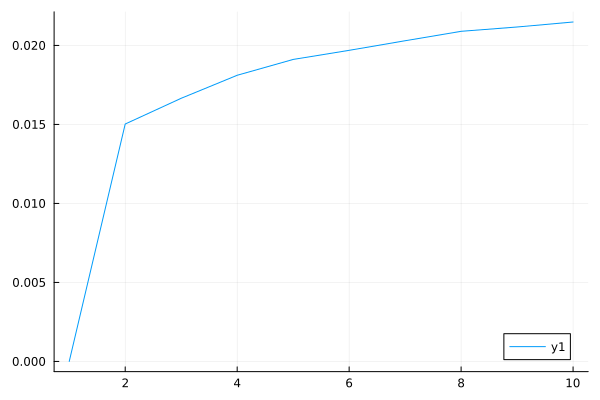

In [153]:
plot(diffusion_over_time)

In [203]:
σs

12-element Vector{Float64}:
 0.00018492966178179513
 0.00011929558052647921
 7.566823799046191e-5
 6.100298508960273e-5
 5.551101219434756e-5
 5.799689635358377e-5
 5.936167838240508e-5
 5.979491743178099e-5
 6.374022239933176e-5
 6.855162729474784e-5
 7.839333817605532e-5
 8.810083184975604e-5

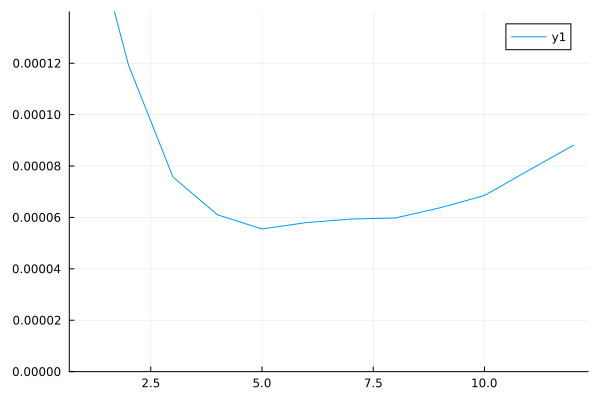

In [202]:
σxs = σx_fit.(sols_with_diffusion)
σys = σy_fit.(sols_with_diffusion)
σzs = σz_fit.(sols_with_diffusion)
σs = (σxs .* σys .* σzs) .^ (1/3)
plot((σxs .* σys .* σzs) .^ (1/3), ylim=(0,140e-6))

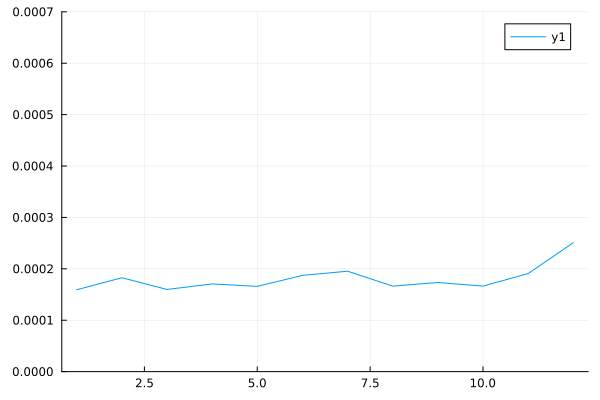

In [201]:
Txs = Tx_fit.(sols_with_diffusion)
Tys = Ty_fit.(sols_with_diffusion)
Tzs = Tz_fit.(sols_with_diffusion)
Ts = (Txs .* Tys .* Tzs) .^ (1/3)
plot((Txs .* Tys .* Tzs) .^ (1/3), ylim=(0,700e-6))

In [22]:
Ts

12-element Vector{Float64}:
 0.00015329051806780344
 0.00016270830437951385
 0.0001490166825754547
 0.00014871864692124782
 0.00015703085680570267
 0.00015241660624928845
 0.00014686860954845848
 0.00017140687918841888
 0.00016579094048937043
 0.0001879359541159818
 0.0001975588579249895
 0.0002427728453816075

In [19]:
n_trajectories1 = 5
n_trajectories2 = 30
n_trajectories_diffusion = 5000
n_times = 10
diffusion_t_end = 20e-6
diffusion_τ_total = 20e-6

(sols_no_diffusion, sols_with_diffusion1, sols_with_diffusion2, diffusion, diffusion_error, diffusion_over_time1, diffusion_over_time2) = 
    compute_trajectories_with_diffusion(
    prob, prob_func_YO!, prob_diffusion, prob_func_diffusion_YO!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

In [20]:
(sols_no_diffusion, sols_with_diffusion1, sols_with_diffusion2, diffusion, diffusion_error, diffusion_over_time1, diffusion_over_time2) = 
    compute_trajectories_with_diffusion(
    prob, prob_func_YO!, prob_diffusion, prob_func_diffusion_YO!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:03:46
Progress: 100%|█████████████████████████████████████████| Time: 0:33:34
Progress: 100%|█████████████████████████████████████████| Time: 0:23:13
Progress: 100%|█████████████████████████████████████████| Time: 0:33:45
Progress: 100%|█████████████████████████████████████████| Time: 0:23:14


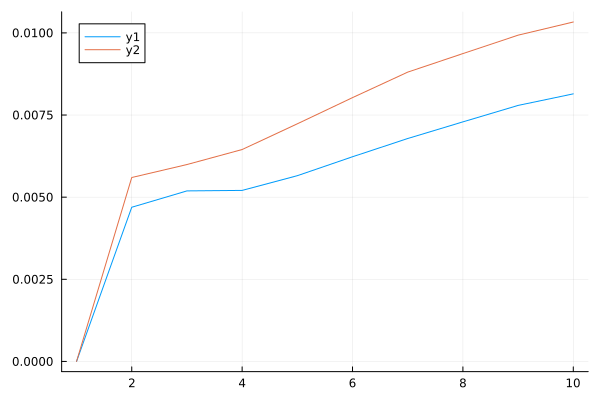

In [94]:
plot(diffusion_over_time1)
plot!(diffusion_over_time2)

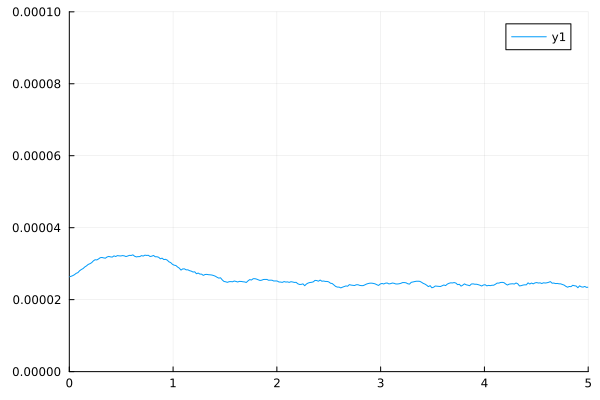

In [23]:
σs = σ_vs_time(sols_with_diffusion2)
times = range(0,5,length(σs))
plot(times, σs, xlim=(0,5), ylim=(0, 100e-6))

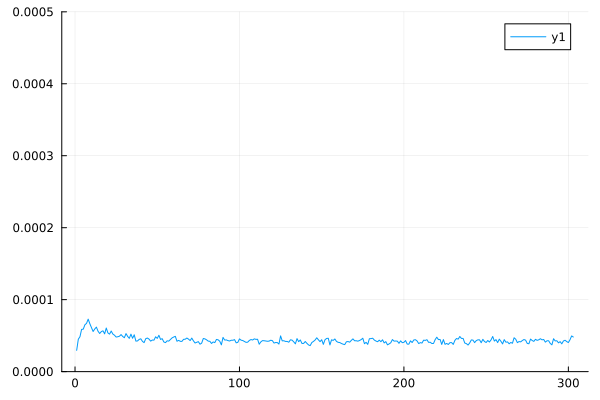

In [24]:
Ts = T_vs_time(sols_with_diffusion2)
plot(Ts, ylim=(0, 0.0005))

In [1401]:
for i ∈ 1:15
    t = sols_with_diffusion2[i*200].t[end] * (1/Γ)
    println( t, " ", sols_with_diffusion2[i*200].prob.p.n_scatters / t )
end

0.01 896200.0
0.01 724300.0
0.01 806600.0
0.01 949900.0
0.01 784000.0
0.01 835000.0
0.01 802600.0
0.01 1.0514e6
0.01 1.1883e6
0.01 1.1013e6
0.01 765700.0
0.01 750200.0
0.01 894100.0
0.002167549653354848 3.2271463720212425e6
0.01 625600.0


In [6]:
n_trajectories1 = 100
n_trajectories2 = 1000
n_trajectories_diffusion = 100000
n_times = 10
diffusion_t_end = 20e-6
diffusion_τ_total = 20e-6
;

In [25]:
(sols_no_diffusion, sols_with_diffusion1, sols_with_diffusion2, diffusion, diffusion_error, diffusion_over_time1, diffusion_over_time2) = 
    compute_trajectories_with_diffusion(
    prob_1plus1, prob_func!, prob_1plus1_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:07:02
Progress: 100%|█████████████████████████████████████████| Time: 1:22:53
Progress: 100%|█████████████████████████████████████████| Time: 1:04:03
Progress: 100%|█████████████████████████████████████████| Time: 1:23:54
Progress: 100%|█████████████████████████████████████████| Time: 1:03:00


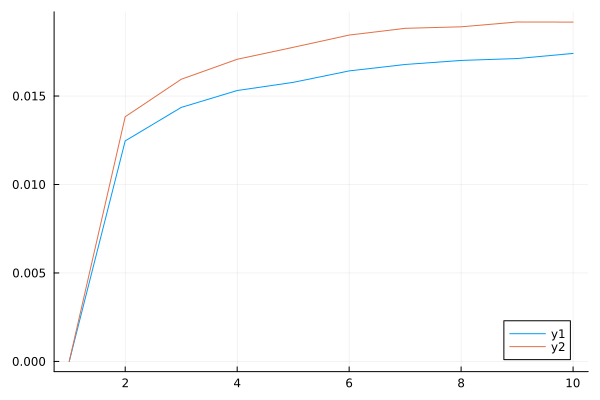

In [27]:
plot(diffusion_over_time1)
plot!(diffusion_over_time2)

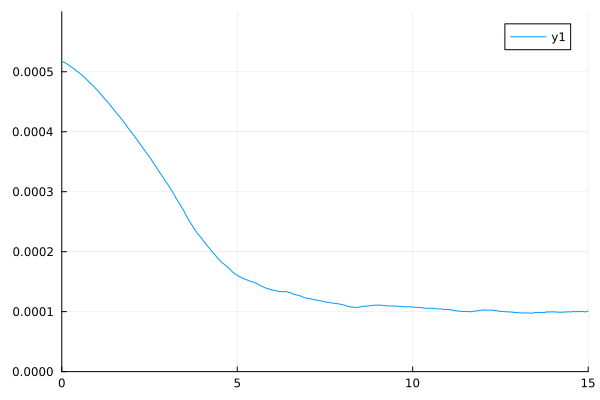

In [28]:
σs = []
for i ∈ 40:645
    σ = σ_geom_ensemble_sol(sols_with_diffusion2, i)
    push!(σs, σ)
end
times = range(0,15,length(σs))
plot(times, σs, xlim=(0,15), ylim=(0, 600e-6))

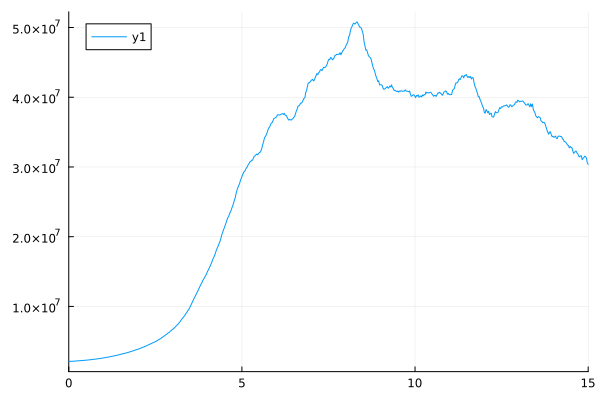

In [29]:
densities = density_vs_time(sols_with_diffusion2)[40:end]
plot(times, densities, xlim=(0,15))

In [30]:
io = open("sizes_2freq.txt", "w") do io
    for x in σs
        println(io, x)
    end
end

io = open("times_2freq.txt", "w") do io
    for x in times
        println(io, x)
    end
end

io = open("densities_2freq.txt", "w") do io
    for x in densities
        println(io, x)
    end
end